In [12]:
!conda install -y Pillow

Solving environment: done

# All requested packages already installed.



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation
import torch
from tqdm import tqdm
import os
from PIL import Image, ImageDraw
from glob import glob
import shutil

from ctrm.viz import simple_plot_2d
from ctrm.utils import set_global_seeds
from ctrm.planner import PrioritizedPlanning as PP
from ctrm.environment.instance import generate_ins_2d_with_obs_hetero_nonfix_agents
from ctrm.learning import reconstruct
from ctrm.roadmap import TimedRoadmap
from ctrm.roadmap.utils import valid_move
from ctrm.roadmap_learned.utils import append_goals, format_trms, merge_samples

<BarContainer object of 10 artists>

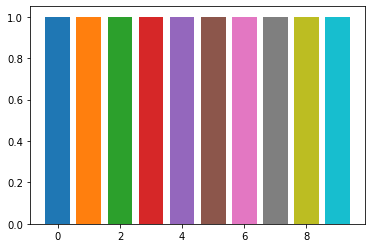

In [14]:
COLORS = list(mcolors.TABLEAU_COLORS.values())
plt.bar(range(len(COLORS)), [1]*len(COLORS), color=COLORS)

# utilities

In [15]:
output_size = 4
fontsize = 18

In [16]:
def savefig(filename):
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.01)

In [17]:
def plot_trm_ctrm(ins, trms, filename, agent=0):
    fig = plt.figure(figsize=(output_size, output_size))
    ax = fig.add_subplot(111)
    color = COLORS[agent % len(COLORS)]
    
    # obstacles
    for o in ins.obs:
        ax.add_patch(plt.Circle(o.pos, o.rad, fc="black", alpha=1))

    # roadmap
    trm = trms[agent]
    T = len(trm.V) - 1
    for t in range(0, T):
        locs_t0 = np.array([v.pos for v in trm.V[t]])
        X_t0, Y_t0 = locs_t0[:, 0], locs_t0[:, 1]
        locs_t1 = np.array([v.pos for v in trm.V[t + 1]])
        X_t1, Y_t1 = locs_t1[:, 0], locs_t1[:, 1]
        for i, neighbors in enumerate(trm.E[t]):
            for j in neighbors:
                ax.plot([X_t0[i], X_t1[j]], [Y_t0[i], Y_t1[j]], color=color, linewidth=0.5, alpha=1)
                
    # start and goal
    # s = ins.starts[agent]
    # g = ins.goals[agent]
    # rad = ins.rads[agent]
    # ax.add_patch(plt.Circle(s, rad, fc=color, alpha=1, ec=color))
    # ax.scatter([g[0]], [g[1]], marker="s", color=color, s=40)
    
    # obstacles
    for o in ins.obs:
        ax.add_patch(plt.Circle(o.pos, o.rad, fc="black", alpha=1))

    # starts and goals
    for a in range(ins.num_agents):
        color = COLORS[a % len(COLORS)]
        g = ins.goals[a]
        s = ins.starts[a]
        rad = ins.rads[a]
        ax.scatter([g[0]], [g[1]], marker="s", color=color, s=10)
        ax.add_patch(plt.Circle(s, rad, fc=color, ec=color))
        
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    savefig(filename)
    plt.close(fig)

# clear the tmp dirctory

In [18]:
GIFDIR = "/workspace/notebooks/fig/tmp"
if os.path.exists(GIFDIR):
    shutil.rmtree(GIFDIR)
os.mkdir(GIFDIR)

# generate one instance

In [19]:
set_global_seeds(13)

ins = generate_ins_2d_with_obs_hetero_nonfix_agents(
    num_agents_min=21,
    num_agents_max=25,
    max_speeds_cands=[0.03125],
    rads_cands=[0.015625],
    obs_num=10,
    obs_size_lower_bound=0.05,
    obs_size_upper_bound=0.08,
)

In [23]:
import pickle
set_global_seeds(13)

ins = pickle.load(open("/workspace/notebooks/CTRM_demo_ins.pkl", "rb"))

## visualize instance

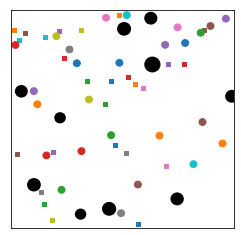

In [24]:
fig = plt.figure(figsize=(output_size, output_size))
ax = fig.add_subplot(1, 1, 1)

# obstacles
for o in ins.obs:
    ax.add_patch(plt.Circle(o.pos, o.rad, fc="black", alpha=1))

# starts and goals
for agent in range(ins.num_agents):
    color = COLORS[agent % len(COLORS)]
    g = ins.goals[agent]
    s = ins.starts[agent]
    rad = ins.rads[agent]
    ax.scatter([g[0]], [g[1]], marker="s", color=color, s=10)
    ax.add_patch(plt.Circle(s, rad, fc=color, ec=color))

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.invert_yaxis()
ax.xaxis.tick_top()
savefig(f"{GIFDIR}/instance.png")

# construct CTRMs

In [25]:
set_global_seeds(0)
pred_basename = "/workspace/trained_models/aamas22-main/best"
N_traj = 25
max_T = 64
prob_uniform_sampling_after_goal = 0.9
prob_uniform_bias = 0.0
prob_uniform_gamma = 5.0
merge_distance_rate = 0.1
max_attempt = 3
randomize_indicator = False
verbose = 0

pred_model, format_input, format_output = reconstruct(pred_basename)
format_input.set_instance(ins)
dim_ind = format_output.get_dim_indicators()
trms = [ TimedRoadmap(ins.starts[i]) for i in range(ins.num_agents) ]

makespan = None

# trajectory
for k_traj in tqdm(
    range(N_traj), disable=(verbose == 0), desc="roadmap_gen"
):
    arr_loc_next = []  # pos at t+1
    arr_loc_current = ins.starts  # pos at t
    arr_loc_prev = ins.starts  # pos at t-1
    arrived_at_goals = [
        False
    ] * ins.num_agents  # true -> goal, false -> not yet

    for t in range(1, max_T + 1):  # timestep
        if t % 20 == 1:
            plot_trm_ctrm(ins, trms, f"{GIFDIR}/roadmap-{k_traj:08d}-{t:08d}.png")
        
        with torch.no_grad():
            X = format_input.get_feature_one_step(
                ins=ins,
                arr_current_pos=arr_loc_current,
                arr_prev_pos=arr_loc_prev,
            )
            X = torch.cat([X] * dim_ind)

            prob_random_walk = (
                1
                - np.exp(
                    -prob_uniform_gamma
                    * t
                    / (max_T if makespan is None else makespan)
                )
            ) * (1 - prob_uniform_bias) + prob_uniform_bias

            if randomize_indicator & (np.random.rand() > prob_random_walk):
                IND = torch.nn.functional.one_hot(torch.randint(0, dim_ind, (ins.num_agents * dim_ind,)), num_classes=dim_ind)
            else:
                IND = torch.nn.functional.one_hot(torch.argmax(pred_model.indicator(X), -1), dim_ind)

            # for resampling
            SAMPLES = (
                pred_model.sample(  # type: ignore
                    X, IND
                )
                .detach()
                .numpy()
            )
        arr_loc_current_repeat = np.repeat(
            np.expand_dims(np.array(arr_loc_current), 0),
            int(X.shape[0] / ins.num_agents),
            axis=0,
        ).reshape(-1, 2)
        Y = arr_loc_current_repeat + SAMPLES[:, :2] * SAMPLES[
            :, 2
        ].reshape(-1, 1)

        for i in range(ins.num_agents):  # agent
            loc_current = arr_loc_current[i]

            # define valid moves
            def valid_edge(pos1: np.ndarray, pos2: np.ndarray) -> bool:
                if min(pos2) < ins.rads[i] or 1 - ins.rads[i] < max(pos2):
                    return False
                return valid_move(
                    pos1, pos2, ins.max_speeds[i], ins.rads[i], ins.objs
                )

            # random walk
            def sample_uniform_i():
                for _ in range(max_attempt):
                    mag = ins.max_speeds[i] * np.random.rand()
                    theta = np.random.rand() * np.pi * 2
                    loc = (
                        np.array([np.sin(theta), np.cos(theta)]) * mag
                        + loc_current
                    )
                    if valid_edge(loc_current, loc):
                        return loc
                return loc_current

            # get sample
            if (
                (
                    not arrived_at_goals[i]
                    and np.random.rand() < prob_random_walk
                )
                or (
                    arrived_at_goals[i]
                    and np.random.rand() > prob_uniform_sampling_after_goal
                )
                or (k_traj < dim_ind)
            ):
                is_valid_sample = False
                for k in range(int(X.shape[0] / ins.num_agents)):
                    loc_pred = Y[i + k * ins.num_agents]
                    if valid_edge(loc_current, loc_pred):
                        is_valid_sample = True
                        break
                if not is_valid_sample:
                    loc_pred = sample_uniform_i()
            else:
                loc_pred = sample_uniform_i()

            # check merge
            loc_next = merge_samples(
                loc=loc_pred,
                t=t,
                agent=i,
                ins=ins,
                trm=trms[i],
                merge_distance=merge_distance_rate * ins.max_speeds[i],
            )
            arr_loc_next.append(loc_next)

            # check goal condition
            if valid_edge(loc_next, ins.goals[i]):
                arrived_at_goals[i] = True

        # check goal cond
        if all(arrived_at_goals):
            if makespan is not None:
                makespan = max(makespan, t)
            else:
                makespan = t
            break

        # update loc_prev
        arr_loc_prev = arr_loc_current
        arr_loc_current = arr_loc_next
        arr_loc_next = []

# align length of roadmaps for planners
format_trms(ins, trms)

# append goals
append_goals(ins, trms)

plot_trm_ctrm(ins, trms, f"{GIFDIR}/roadmap-{N_traj:08d}-{makespan:08d}.png")

## gif of constructing CTRMs


In [27]:
files = sorted(glob(f"{GIFDIR}/roadmap-*.png"))  
images = list(map(lambda file : Image.open(file), files))
images[0].save(f"{GIFDIR}/../roadmap-construction.gif", save_all=True , append_images=images[1:] , duration=0, loop=0)

# CTRMs for all agents

In [28]:
for agent in tqdm(range(ins.num_agents)):
    plot_trm_ctrm(ins, trms, f"{GIFDIR}/trm-{agent:08d}.png", agent=agent)

100%|██████████| 26/26 [03:44<00:00,  8.64s/it]


## gif of CTRMs for all agents

In [29]:
files = sorted(glob(f"{GIFDIR}/trm-*.png"))  
images = list(map(lambda file : Image.open(file), files))
images[0].save(f"{GIFDIR}/../roadmaps.gif", save_all=True , append_images=images[1:] , duration=300, loop=1)

# planning

In [30]:
planner = PP(ins, trms, time_limit=300, verbose=1)
res = planner.solve()

22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | _solve is started, time_limit: 300 sec
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-0 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-1 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-2 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-3 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-4 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-5 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-6 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-7 starts planning
22/01/14 05:55:14 | INFO     | planner.py       | info             | L085 | agent-8 s

# visualize solution

In [31]:
for t in tqdm(range(res.maximum_costs + 1)):
    fig = plt.figure(figsize=(output_size, output_size))
    ax = fig.add_subplot(1, 1, 1)
    
    # obstacles
    for o in ins.obs:
        ax.add_patch(plt.Circle(o.pos, o.rad, fc="black", alpha=1))

    # goals
    for agent in range(ins.num_agents):
        color = COLORS[agent % len(COLORS)]
        g = ins.goals[agent]
        ax.scatter([g[0]], [g[1]], marker="s", color=color, s=10)

    # agents
    for agent in range(ins.num_agents):
        color = COLORS[agent % len(COLORS)]
        pos = res.paths[agent][t].pos
        rad = ins.rads[agent]
        path_numpy = np.array([ v.pos for v in res.paths[agent][:t+1] ])
        ax.plot(path_numpy[:,0], path_numpy[:,1], color=color, linewidth=1)
        if all(pos == ins.goals[agent]):
            ax.add_patch(plt.Circle(pos, rad, fc="white", ec=color))
        else:
            ax.add_patch(plt.Circle(pos, rad, fc=color, ec=color))

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    savefig(f"{GIFDIR}/solution-{t:08d}.png")
    plt.close(fig)

100%|██████████| 42/42 [00:12<00:00,  3.39it/s]


## gif for solution

In [32]:
files = sorted(glob(f"{GIFDIR}/solution-*.png"))  
images = list(map(lambda file : Image.open(file), files))
images[0].save(f"{GIFDIR}/../solution.gif", save_all=True , append_images=images[1:] , duration=1, loop=0)

# composited GIF

In [33]:
files_roadmap = sorted(glob(f"{GIFDIR}/roadmap-*.png"))
files_trm = sorted(glob(f"{GIFDIR}/trm-*.png"))
files_solution = sorted(glob(f"{GIFDIR}/solution-*.png"))  

img_instance = Image.open(f"{GIFDIR}/instance.png")
img_roadmap = Image.open(files_roadmap[0])
img_trm = Image.open(files_trm[0])
img_solution = Image.open(files_solution[0])

w = img_instance.width
h = img_instance.height
cnt = 0

def generate_one_image(img_roadmap, img_trm, img_solution, cnt, focus=0):
    buf = 3
    img_merge = Image.new("RGBA", (w * 3 + buf, h + buf))
    img_merge.paste(img_solution, (w*0, 0))
    img_merge.paste(img_roadmap,  (w*1, 0))
    img_merge.paste(img_trm,      (w*2, 0))
    im_shadow = Image.new("RGBA", (w * 3 + buf, h + buf))
    draw = ImageDraw.Draw(im_shadow)
    draw.rectangle((w*focus, 0, w*(focus+1)+buf, h+buf), outline=(0, 0, 0, 255), width=buf*2)    
    img_merge = Image.alpha_composite(img_merge, im_shadow)
    cnt += 1
    return img_merge

images = []

for file in tqdm(files_roadmap):
    img_roadmap = Image.open(file)
    images.append(generate_one_image(img_roadmap, img_trm, img_solution, cnt, focus=1))
    
for file in tqdm(files_trm):
    img_trm = Image.open(file)
    for _ in range(200):
        images.append(generate_one_image(img_roadmap, img_trm, img_solution, cnt, focus=2))
    
for file in tqdm(files_solution):
    img_solution = Image.open(file)
    images.append(generate_one_image(img_roadmap, img_trm, img_solution, cnt, focus=0))
    
images[0].save(f"{GIFDIR}/../ctrm.gif", save_all=True , append_images=images[1:] , duration=1, loop=0)

100%|██████████| 42/42 [00:00<00:00, 135.14it/s]
